In [ ]:
import tensorflow as tf### models
import pandas as pd ### reading and processing data
import seaborn as sns ### visualization
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
from tensorflow.keras.layers import Normalization, Dense, InputLayer,BatchNormalization,Dropout
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError,categorical_crossentropy,MeanAbsolutePercentageError,BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError,MeanAbsolutePercentageError,Accuracy,hinge,Mean
from tensorflow.keras.optimizers import Adam , AdamW ,Ftrl, RMSprop
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## **Data Preparation**

In [ ]:
data = pd.read_csv("/content/train_data_covid.csv")
data.tail()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Deaths,Confirmed,OxygenTanks,PopulationDensityPerSqKm
14996,14997,2021-05-17,8:00 AM,Lakshadweep,-,-,3633,14,4767,4046,490
14997,14998,2021-05-17,8:00 AM,Madhya Pradesh,-,-,629741,6992,731385,1195,595
14998,14999,2021-05-17,8:00 AM,Maharashtra,-,-,4826371,81486,5378452,9289,195
14999,15000,2021-05-17,8:00 AM,Manipur,-,-,32674,578,39729,576,296
15000,15001,2021-05-17,8:00 AM,Meghalaya,-,-,18478,320,23332,191,514


In [ ]:
# data['ConfirmedIndianNational'].dtype
# data['ConfirmedIndianNational'] = data['ConfirmedIndianNational'].replace('-', np.nan)
# data['ConfirmedIndianNational'] = data['ConfirmedIndianNational'].astype(float)
# mn=data['ConfirmedIndianNational'].mean()
# data['ConfirmedIndianNational'].fillna(mn, inplace=True)
# #data['ConfirmedIndianNational'].replace('-',mn )

In [ ]:
# data['ConfirmedForeignNational'].dtype
# data['ConfirmedForeignNational'] = data['ConfirmedForeignNational'].replace('-', np.nan)
# data['ConfirmedForeignNational'] = data['ConfirmedForeignNational'].astype(float)
# mn=data['ConfirmedForeignNational'].mean()
# data['ConfirmedForeignNational'].fillna(mn, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
data['StateID'] = le.fit_transform(data['State/UnionTerritory'])
data['Date'] = pd.to_datetime(data['Date']).astype('int')
data['Time'] = pd.to_datetime(data['Time']).astype('int')
data['Confirmed'] = data['Confirmed'].astype('int')
# data['ConfirmedIndianNational']=data['ConfirmedIndianNational'].astype('int')
# data['ConfirmedForeignNational']=data['ConfirmedForeignNational'].astype('int')
data['Deaths'] = data['Deaths'].astype('int')
data['OxygenTanks'] = data['OxygenTanks'].astype('int')
data['PopulationDensityPerSqKm'] = data['PopulationDensityPerSqKm'].astype('int')

<ipython-input-5-1341b669739e>:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Time'] = pd.to_datetime(data['Time']).astype('int')


In [ ]:
data1=data[['Date', 'Time','StateID','Cured', 'Confirmed', 'OxygenTanks','PopulationDensityPerSqKm','Deaths']]

In [ ]:
data2=data1[['Deaths']]

In [ ]:
tensor_data = tf.constant(data1)
tensor_data = tf.cast(tensor_data, tf.float32)

In [ ]:
tensor_data = tf.random.shuffle(tensor_data)

In [ ]:
X = tensor_data[:,0:7]
print(X.shape)

(15001, 7)


In [ ]:
tensor_data1 = tf.constant(data2)
tensor_data1 = tf.cast(tensor_data1, tf.float32)

In [ ]:
y = tensor_data[:,-1]
print(y[:6].shape)
y = tf.expand_dims(y, axis = -1)
print(y.shape)

(6,)
(15001, 1)


In [ ]:
normalizer=Normalization()
normalizer.adapt(X)
normalizer(X)[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[-1.6440601 ,  4.14501   ,  1.1194674 , -0.4805517 , -0.4756127 ,
         1.1175381 ,  1.2805918 ],
       [-0.61193484, -0.35601312, -1.4367946 , -0.3874188 , -0.36330274,
        -0.556358  ,  0.34997293],
       [-1.0751747 , -0.35601312,  0.5905856 , -0.48054054, -0.475486  ,
        -1.5276395 , -1.1796081 ],
       [-0.20558994, -0.35601312, -1.0842067 , -0.33566684, -0.2499146 ,
        -0.41182408,  0.57767755],
       [ 0.94843113, -0.35601312, -0.6434719 ,  0.23908278,  0.18119235,
         0.85371184,  1.0578372 ]], dtype=float32)>

In [ ]:
print(y.shape)

(15001, 1)


In [ ]:
print(X.shape)

(15001, 7)


In [ ]:
TRAIN_RATIO = 0.95
VAL_RATIO = 0.05
# TEST_RATIO = 0.1
DATASET_SIZE = len(X)

In [ ]:
X_train = X[:int(DATASET_SIZE*TRAIN_RATIO)]
y_train = y[:int(DATASET_SIZE*TRAIN_RATIO)]
print(X_train.shape)
print(y_train.shape)

(14250, 7)
(14250, 1)


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:

X_val = X[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
y_val = y[int(DATASET_SIZE*TRAIN_RATIO):int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO))]
print(X_val.shape)
print(y_val.shape)

(751, 7)
(751, 1)


In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# X_test = X[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
# y_test = y[int(DATASET_SIZE*(TRAIN_RATIO+VAL_RATIO)):]
# print(X_test.shape)
# print(y_test.shape)

In [ ]:
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# test_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
normalizer = Normalization()
normalizer.adapt(X_train)
normalizer(X)[:5]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[-1.6412916 ,  4.1093707 ,  1.1207571 , -0.4797255 , -0.47456917,
         1.1165001 ,  1.2790267 ],
       [-0.6098013 , -0.3943978 , -1.4372959 , -0.38674182, -0.36253035,
        -0.55596787,  0.34956384],
       [-1.0727562 , -0.3943978 ,  0.59150475, -0.47971436, -0.47444275,
        -1.5264208 , -1.1781173 ],
       [-0.20370637, -0.3943978 , -1.084461  , -0.3350728 , -0.24941595,
        -0.4115573 ,  0.5769856 ],
       [ 0.94960475, -0.3943978 , -0.64341736,  0.23875591,  0.1806502 ,
         0.852899  ,  1.056549  ]], dtype=float32)>

**Model Training**

In [ ]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(7,)),
    normalizer,
     Dense(64, activation='relu'),
     Dense(64, activation='relu'),
     Dense(64, activation='relu'),
    #  Dense(28, activation='relu'),
    #  Dropout(0.2),
     Dense(1)
])


In [ ]:
model.compile(
        loss = Huber(),
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.09, momentum=0.35),
    )

In [ ]:
history = model.fit(X_train,y_train, validation_data=(X_val,y_val), epochs = 160,batch_size=32, verbose = 1)

Epoch 1/160
446/446 [==============================] - 3s 5ms/step - loss: nan - val_loss: nan
Epoch 2/160
446/446 [==============================] - 2s 5ms/step - loss: nan - val_loss: nan
Epoch 3/160
446/446 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 4/160
446/446 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 5/160
446/446 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 6/160
446/446 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 7/160
446/446 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 8/160
446/446 [==============================] - 1s 3ms/step - loss: nan - val_loss: nan
Epoch 9/160
446/446 [==============================] - 2s 4ms/step - loss: nan - val_loss: nan
Epoch 10/160
446/446 [==============================] - 2s 5ms/step - loss: nan - val_loss: nan
Epoch 11/160
446/446 [===========================

In [ ]:
# tf.keras.layers.Reshape((7,))

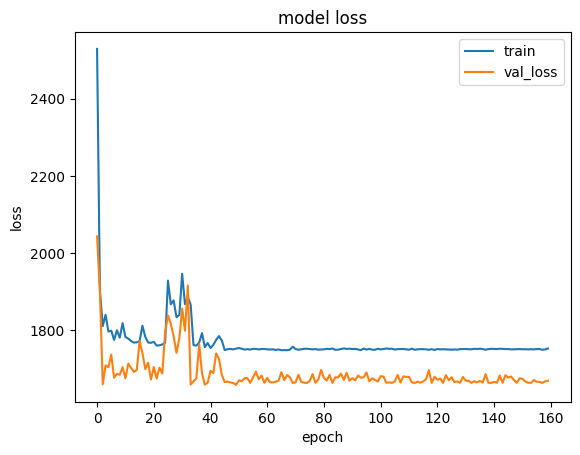

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'])
plt.show()

## **Model Evaluation and Testing**

In [ ]:
# model.evaluate(X_test,y_test)

In [ ]:
# model.predict(tf.expand_dims(X_test[0], axis = 0 ))

In [ ]:
# y_test

In [ ]:
# y_true = list(y_test[:,0].numpy())
# print(y_true)

In [ ]:
# y_pred = list(model.predict(X_test)[:,0])
# print(y_pred)

**Teast Data**

In [ ]:
test_data = pd.read_csv("/content/test_data_covid.csv")
test_data.head()

,Sno,Date,Time,State/UnionTerritory,ConfirmedIndianNational,ConfirmedForeignNational,Cured,Confirmed,OxygenTanks,PopulationDensityPerSqKm
0,15001,2021-05-17,8:00 AM,Meghalaya,-,-,18478,23332,191,514
1,15002,2021-05-17,8:00 AM,Mizoram,-,-,6687,8829,1111,563
2,15003,2021-05-17,8:00 AM,Nagaland,-,-,13767,18076,9896,577
3,15004,2021-05-17,8:00 AM,Odisha,-,-,514532,612224,6091,615
4,15005,2021-05-17,8:00 AM,Puducherry,-,-,65689,84506,220,573


In [ ]:
# data['ConfirmedIndianNational'].dtype
# data['ConfirmedIndianNational'] = data['ConfirmedIndianNational'].replace('-', np.nan)
# data['ConfirmedIndianNational'] = data['ConfirmedIndianNational'].astype(float)
# mn=data['ConfirmedIndianNational'].mean()
# data['ConfirmedIndianNational'].fillna(mn, inplace=True)
# #data['ConfirmedIndianNational'].replace('-',mn )

In [ ]:
# data['ConfirmedForeignNational'].dtype
# data['ConfirmedForeignNational'] = data['ConfirmedForeignNational'].replace('-', np.nan)
# data['ConfirmedForeignNational'] = data['ConfirmedForeignNational'].astype(float)
# mn=data['ConfirmedForeignNational'].mean()
# data['ConfirmedForeignNational'].fillna(mn, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
test_data['StateID'] = le.fit_transform(test_data['State/UnionTerritory'])
test_data['Confirmed'] = test_data['Confirmed'].astype('int')
test_data['Date'] = pd.to_datetime(test_data['Date']).astype('int')
test_data['Time'] = pd.to_datetime(test_data['Time']).astype('int')
test_data['OxygenTanks'] = test_data['OxygenTanks'].astype('int')
test_data['PopulationDensityPerSqKm'] = test_data['PopulationDensityPerSqKm'].astype('int')

In [ ]:
test_data1=test_data[['Date', 'Time','StateID','Cured', 'Confirmed', 'OxygenTanks','PopulationDensityPerSqKm']]

In [ ]:
# test_data1.insert(6,'Deaths',0)
test_data1.tail()

,Date,Time,StateID,Cured,Confirmed,OxygenTanks,PopulationDensityPerSqKm
3105,1628640000000000000,1714809600000000000,37,638410,650353,8796,659
3106,1628640000000000000,1714809600000000000,38,77811,80660,9330,488
3107,1628640000000000000,1714809600000000000,40,334650,342462,6290,686
3108,1628640000000000000,1714809600000000000,39,1685492,1708812,723,115
3109,1628640000000000000,1714809600000000000,41,1506532,1534999,5380,624


In [ ]:
tensor_test_data = tf.constant(test_data1)
tensor_test_data = tf.cast(tensor_test_data, tf.float32)

In [ ]:
X_test_data =tensor_test_data[:,0:7]
print(X_test_data.shape)

(3110, 7)


In [ ]:
y_test_data_pred=list(model.predict(X_test_data)[:,0])
print(y_test_data_pred)

98/98 [==============================] - 0s 3ms/step
[144.78314, 144.78314, 144.78314, 9817.027, 144.78314, 144.78314, 9817.027, 144.78314, 9817.027, 144.78314, 144.78314, 144.78314, 9817.027, 9817.027, 144.78314, 9817.027, 144.78314, 144.78314, 9817.027, 144.78314, 9817.027, 144.78314, 9817.027, 144.78314, 9817.027, 9817.027, 144.78314, 144.78314, 144.78314, 9817.027, 9817.027, 144.78314, 144.78314, 9817.027, 9817.027, 144.78314, 144.78314, 144.78314, 144.78314, 9817.027, 144.78314, 144.78314, 9817.027, 144.78314, 9817.027, 144.78314, 144.78314, 144.78314, 9817.027, 9817.027, 144.78314, 9817.027, 144.78314, 144.78314, 9817.027, 144.78314, 9817.027, 144.78314, 9817.027, 144.78314, 9817.027, 9817.027, 144.78314, 144.78314, 144.78314, 9817.027, 9817.027, 144.78314, 144.78314, 9817.027, 9817.027, 144.78314, 144.78314, 144.78314, 144.78314, 9817.027, 144.78314, 144.78314, 9817.027, 144.78314, 9817.027, 144.78314, 144.78314, 144.78314, 9817.027, 9817.027, 144.78314, 9817.027, 144.78314, 144

In [ ]:
y_test_data_pred1=list(model.predict(X_test_data1)[:,0])
print(y_test_data_pred1)

NameError: name 'X_test_data1' is not defined

In [ ]:
# count = 0
# i = 0
# while i < 3110:
#   if y_test_data_pred[i] < 0:
#     count = count + 1
#   i = i + 1
#   print(y_test_data_pred[i])
#   count += 1
#   i+=1


# count

In [ ]:
test_data3=test_data[['Sno']]
test_data3

,Sno
0,15001
1,15002
2,15003
3,15004
4,15005
...,...
3105,18106
3106,18107
3107,18108
3108,18109


In [ ]:
y_test69=pd.DataFrame(y_test_data_pred)
y_test69.rename(columns={0: 'Deaths'}, inplace=True)
X_column = tensor_test_data[:, 0] # Corrected the key to select the first column
column_x=list(X_column)
y_test69.insert(0, "Sno", test_data3, True)
y_test69

,Sno,Deaths
0,15001,144.783142
1,15002,144.783142
2,15003,144.783142
3,15004,9817.027344
4,15005,144.783142
...,...,...
3105,18106,144.783142
3106,18107,144.783142
3107,18108,144.783142
3108,18109,9817.027344


In [ ]:
y_test69.to_csv('/content/drive/My Drive/death_pred72.csv', index=False)

In [ ]:
# df_verify = pd.read_csv('/content/drive/My Drive/death_pred24.csv')
# df_verify